![Logo BV IBMEC](https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/logo-bv-ibmec-notebooks.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-iania/IBMEC-BV-Modelos-Preditivos/blob/main/notebooks/NB02_Classification.ipynb)

# NB02 — Classificação: Default PF 30+ (FP&A Banco BV)

**Objetivo da aula:**
- prever **P(default 30+)** com foco em decisão de crédito
- entender **AUC/ROC**, **PR-AUC**, **cutoff** e **custo em R$**
- comparar **Logística vs Árvore vs GBM** com validação temporal


## 1) Setup e contexto

Em classificação, o modelo prevê **probabilidade**. A decisão vem depois, via cutoff.

Mapa do notebook:
1. Sanidade dos dados
2. Split temporal (80/20)
3. Métricas 101
4. Treino dos 3 modelos
5. Cutoff x custo x payoff


### 1.1) Imports

O que vamos fazer: carregar bibliotecas para dados, modelagem e visualização.

O que observar no output: confirmação simples de ambiente pronto.


In [1]:
import pandas as pd  # biblioteca principal para manipular dados tabulares
import numpy as np  # biblioteca para operações numéricas
import matplotlib.pyplot as plt  # biblioteca de gráficos estáticos
import matplotlib.ticker as mtick  # utilitário para formatar eixo em percentual

import plotly.express as px  # gráficos interativos simples
import plotly.graph_objects as go  # gráficos interativos com múltiplas curvas

print('Imports de dados e visualização carregados.')  # mensagem de validação do ambiente


Imports de dados e visualização carregados.


### 1.1.1) Imports de modelagem

Agora carregamos pré-processamento, modelos e métricas de avaliação.


In [2]:
from sklearn.compose import ColumnTransformer  # aplica transformações por grupo de colunas
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # tratamento de categóricas e numéricas
from sklearn.pipeline import Pipeline  # encadeia pré-processamento e modelo

from sklearn.linear_model import LogisticRegression  # modelo linear de classificação
from sklearn.tree import DecisionTreeClassifier  # árvore de decisão
from sklearn.ensemble import GradientBoostingClassifier  # boosting de árvores

from sklearn.metrics import (  # métricas de avaliação para classificação
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

print('Imports de modelagem carregados.')  # confirma bibliotecas de ML


Imports de modelagem carregados.


### 1.2) Configuração básica

O que vamos fazer: fixar semente e melhorar legibilidade das tabelas.


In [3]:
np.random.seed(42)  # garante reprodutibilidade de passos com aleatoriedade
pd.set_option('display.max_columns', 60)  # aumenta número de colunas visíveis na tela
pd.set_option('display.width', 150)  # amplia largura para leitura no notebook

print('Seed fixa: 42')  # confirma configuração


Seed fixa: 42


## 2) Carregamento e sanidade do dataset

### 2.1) Vamos carregar o dataset do GitHub raw (ambiente controlado)


In [4]:
url = 'https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/bv_pf_default30_sintetico.csv'  # define fonte única do dataset

df = pd.read_csv(url)  # carrega dataset direto da URL raw

print('Fonte:', url)  # confirma origem dos dados
print(f'Shape inicial: {df.shape[0]:,} linhas x {df.shape[1]} colunas')  # imprime tamanho da base


Fonte: https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/bv_pf_default30_sintetico.csv
Shape inicial: 30,000 linhas x 20 colunas


### 2.2) Ajustar data e ordenar no tempo

O que vamos fazer: converter `dt` para datetime, ordenar por data e conferir as primeiras linhas.


In [5]:
df['dt'] = pd.to_datetime(df['dt'])  # converte coluna dt para tipo data

df = df.sort_values('dt').reset_index(drop=True)  # ordena cronologicamente e reseta índice

df.head(8)  # exibe primeiras linhas após ordenação


,id,dt,selic,idade,renda_mensal,score_interno,valor_solicitado,prazo_meses,canal,utilizacao_limite,atraso_antes_30d,atraso_antes_60d,taxa_mensal,parcela_mensal,pti,default_30p,ead,lgd,loss_if_default,profit_if_good
0,1,2019-01-01,8.545462,23,4133.796015,776,7196.484870,48,agencia,0.172912,0,0,0.009198,153.236287,0.050000,0,5037.539409,0.583379,2938.795183,529.523098
1,13,2019-01-01,9.034833,75,3239.111340,508,30845.104833,48,parceiro,0.277339,0,0,0.016357,667.833578,0.206178,1,21591.573383,0.544437,11755.261301,4036.356449
2,12,2019-01-01,8.335367,23,3222.842852,718,41634.145234,36,agencia,0.609856,0,0,0.010481,1178.321433,0.365616,0,29143.901664,0.396307,11549.943374,2618.087874
3,11,2019-01-01,8.890100,24,4535.509945,867,17741.443613,36,agencia,0.363216,0,0,0.008000,499.914456,0.110222,0,12419.010529,0.497153,6174.143505,851.589293
4,10,2019-01-01,9.232289,64,3486.605042,655,5090.028927,60,digital,0.625163,1,0,0.021139,90.213664,0.050000,0,3563.020249,0.528968,1884.723772,1075.969673
5,8,2019-01-01,8.429328,53,4148.379210,621,15666.277316,24,digital,0.836055,0,1,0.022712,670.552208,0.161642,0,10966.394121,0.595146,6526.607745,1423.252262
6,9,2019-01-01,8.650186,58,3310.667954,573,10910.493221,60,parceiro,0.537839,1,0,0.022104,193.900088,0.058568,0,7637.345255,0.491350,3752.612205,2411.706862
7,6,2019-01-01,8.981705,68,7600.026783,642,23010.319145,24,agencia,0.401419,0,0,0.012570,973.225100,0.128055,0,16107.223402,0.564561,9093.516231,1156.944183


### 2.3) Visão rápida da estrutura

O que observar: tipos de coluna e taxa geral de default.


In [6]:
shape_df = pd.DataFrame({'metric': ['linhas', 'colunas'], 'valor': [df.shape[0], df.shape[1]]})  # tabela curta de tamanho

tipos_df = df.dtypes.reset_index()  # transforma tipos em DataFrame para leitura mais limpa
tipos_df.columns = ['coluna', 'tipo']  # renomeia colunas da tabela de tipos

taxa_default = df['default_30p'].mean()  # calcula taxa média de default

print(f'Taxa de default (base completa): {taxa_default:.2%}')  # imprime taxa em formato percentual
shape_df  # exibe tabela de tamanho da base


Taxa de default (base completa): 8.60%


,metric,valor
0,linhas,30000
1,colunas,20


### 2.4) Tabela de tipos (amostra)

Por que importa: ajuda a entender variáveis numéricas vs categóricas.


In [7]:
tipos_df.head(20)  # exibe primeiras colunas com seus tipos


,coluna,tipo
0,id,int64
1,dt,datetime64[us]
2,selic,float64
3,idade,int64
4,renda_mensal,float64
5,score_interno,int64
6,valor_solicitado,float64
7,prazo_meses,int64
8,canal,str
9,utilizacao_limite,float64


### 2.5) Plot de sanidade: taxa de default

O que observar: classe positiva (default) é menor, então PR-AUC e cutoff são essenciais.


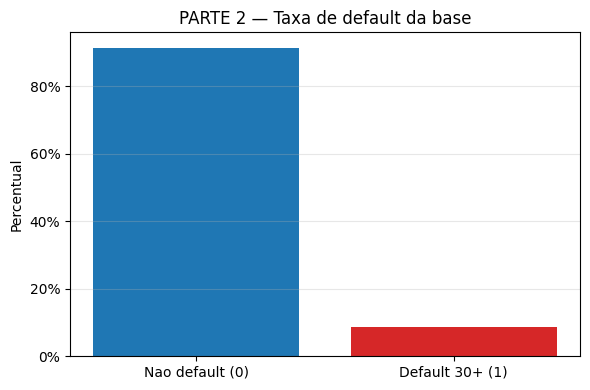

In [8]:
class_rate = df['default_30p'].value_counts(normalize=True).sort_index()  # calcula participação percentual de cada classe

fig, ax = plt.subplots(figsize=(6, 4))  # cria figura matplotlib
ax.bar(['Nao default (0)', 'Default 30+ (1)'], class_rate.values, color=['#1f77b4', '#d62728'])  # plota barras de classe
ax.set_title('PARTE 2 — Taxa de default da base')  # define título padronizado
ax.set_ylabel('Percentual')  # define eixo Y
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # formata eixo Y em percentual
ax.grid(axis='y', alpha=0.3)  # adiciona grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


Leitura FP&A: problema desbalanceado exige olhar além de acurácia bruta.


### 2.6) Plot de sanidade: distribuição de PTI

O que observar: onde a carteira está concentrada em comprometimento de renda.


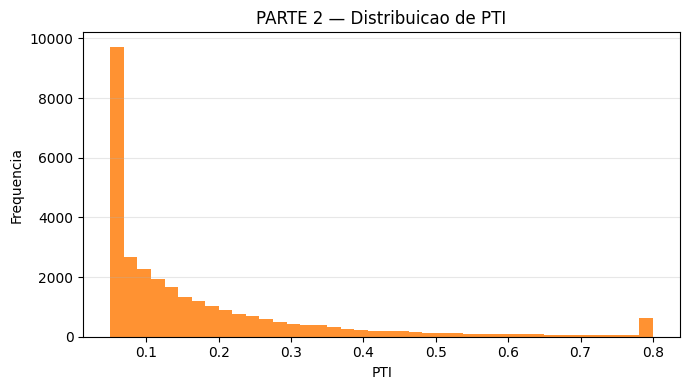

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura para histograma de PTI
ax.hist(df['pti'], bins=40, color='#ff7f0e', alpha=0.85)  # plota distribuição de PTI
ax.set_title('PARTE 2 — Distribuicao de PTI')  # define título padronizado
ax.set_xlabel('PTI')  # define eixo X
ax.set_ylabel('Frequencia')  # define eixo Y
ax.grid(axis='y', alpha=0.3)  # adiciona grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


Leitura FP&A: PTI muito elevado tende a aumentar vulnerabilidade de pagamento.


### 2.7) Plot de sanidade: distribuição de score interno

O que observar: dispersão do risco medido internamente.


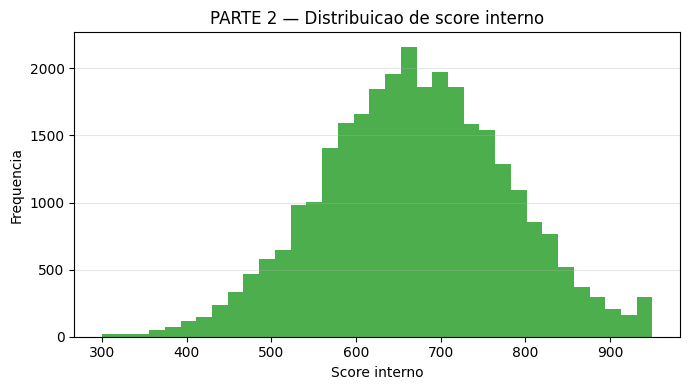

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura para histograma de score
ax.hist(df['score_interno'], bins=35, color='#2ca02c', alpha=0.85)  # plota distribuição de score
ax.set_title('PARTE 2 — Distribuicao de score interno')  # define título padronizado
ax.set_xlabel('Score interno')  # define eixo X
ax.set_ylabel('Frequencia')  # define eixo Y
ax.grid(axis='y', alpha=0.3)  # adiciona grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


Leitura FP&A: score organiza clientes por risco esperado, útil para ranking e cutoff.


### 2.8) Plot de sanidade: SELIC ao longo do tempo

O que observar: contexto macro pode deslocar risco da carteira.


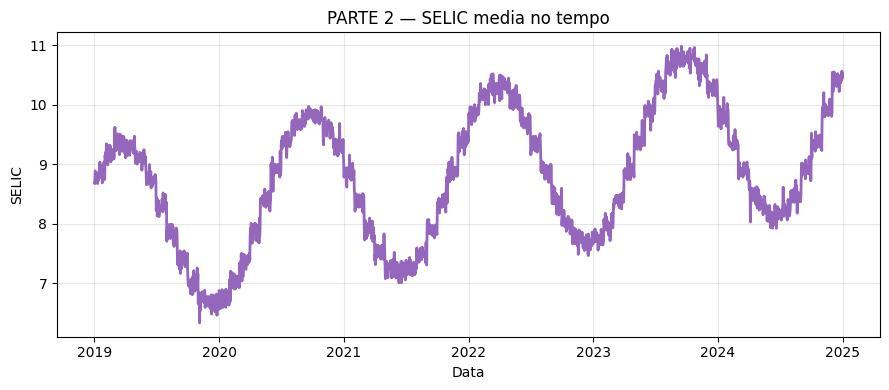

In [11]:
selic_mes = df.groupby('dt', as_index=False)['selic'].mean()  # calcula SELIC média por data da base

fig, ax = plt.subplots(figsize=(9, 4))  # cria figura para série temporal
ax.plot(selic_mes['dt'], selic_mes['selic'], color='#9467bd', linewidth=2)  # plota linha da SELIC
ax.set_title('PARTE 2 — SELIC media no tempo')  # define título padronizado
ax.set_xlabel('Data')  # define eixo X
ax.set_ylabel('SELIC')  # define eixo Y
ax.grid(alpha=0.3)  # adiciona grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


## 3) Split temporal (80/20)

Sem embaralhar: treino no passado, teste no futuro.


In [12]:
split_idx = int(len(df) * 0.8)  # calcula ponto de corte temporal de 80%

train = df.iloc[:split_idx].copy().reset_index(drop=True)  # separa parte de treino

test = df.iloc[split_idx:].copy().reset_index(drop=True)  # separa parte de teste

summary_split = pd.DataFrame({  # monta resumo limpo de split temporal
    'bloco': ['treino', 'teste'],
    'linhas': [len(train), len(test)],
    'dt_inicio': [train['dt'].min().date(), test['dt'].min().date()],
    'dt_fim': [train['dt'].max().date(), test['dt'].max().date()],
    'taxa_default': [train['default_30p'].mean(), test['default_30p'].mean()],
})

summary_split['taxa_default'] = summary_split['taxa_default'].map(lambda x: f'{x:.2%}')  # formata taxa como percentual
summary_split  # exibe resumo de split


,bloco,linhas,dt_inicio,dt_fim,taxa_default
0,treino,24000,2019-01-01,2023-10-12,8.28%
1,teste,6000,2023-10-12,2024-12-31,9.88%


Leitura FP&A: este é o desenho mais próximo da produção, onde sempre prevemos períodos futuros.


## 4) Feature set e separação risco x custo

Separar variáveis de risco (inputs do modelo) das variáveis de impacto financeiro (apenas custo).


In [13]:
target = 'default_30p'  # define variável alvo da classificação

num_features = [  # define variáveis numéricas de risco usadas no modelo
    'selic',
    'idade',
    'renda_mensal',
    'score_interno',
    'valor_solicitado',
    'prazo_meses',
    'utilizacao_limite',
    'atraso_antes_30d',
    'atraso_antes_60d',
    'taxa_mensal',
    'parcela_mensal',
    'pti',
]

cat_features = ['canal']  # define variável categórica usada no modelo

cost_features = ['loss_if_default', 'profit_if_good', 'ead', 'lgd']  # define variáveis financeiras usadas só para payoff


### 4.1) Conferência das variáveis

O que observar: quantidade de variáveis em cada bloco.


In [14]:
feature_overview = pd.DataFrame({  # cria tabela para documentação da aula
    'grupo': ['numericas_modelo', 'categoricas_modelo', 'financeiras_somente_custo'],
    'qtd_colunas': [len(num_features), len(cat_features), len(cost_features)],
    'colunas': [', '.join(num_features), ', '.join(cat_features), ', '.join(cost_features)],
})

feature_overview  # exibe tabela de governança das colunas


,grupo,qtd_colunas,colunas
0,numericas_modelo,12,"selic, idade, renda_mensal, score_interno, val..."
1,categoricas_modelo,1,canal
2,financeiras_somente_custo,4,"loss_if_default, profit_if_good, ead, lgd"


## 5) Pré-processamento e primeiro modelo (Logística)

### 5.1) Pré-processamento: padronizar numéricas e one-hot em categóricas


In [15]:
prep = ColumnTransformer(  # cria pipeline de transformação por tipo de coluna
    transformers=[
        ('num', StandardScaler(), num_features),  # padroniza variáveis numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # codifica categóricas
    ]
)

print('Pré-processamento definido.')  # confirma etapa pronta


Pré-processamento definido.


### 5.2) Agora treinaremos a Logística para gerar probabilidades

O que observar: primeiras probabilidades previstas no teste.


In [16]:
X_train = train[num_features + cat_features].copy()  # separa features de treino
X_test = test[num_features + cat_features].copy()  # separa features de teste

y_train = train[target].copy()  # separa alvo de treino
y_test = test[target].copy()  # separa alvo de teste

pipe_log = Pipeline(steps=[('prep', prep), ('model', LogisticRegression(max_iter=2000, random_state=42))])  # monta pipeline logístico

pipe_log.fit(X_train, y_train)  # treina logística no treino

proba_log_test = pipe_log.predict_proba(X_test)[:, 1]  # calcula probabilidade de default no teste
proba_baseline = np.repeat(y_train.mean(), len(y_test))  # cria baseline probabilístico constante

print('Primeiras probabilidades (logística):', np.round(proba_log_test[:8], 4))  # mostra amostra curta


Primeiras probabilidades (logística): [0.0397 0.0992 0.0462 0.0438 0.034  0.045  0.1074 0.271 ]


## 6) Visualizações (Plotly)

Aqui usamos Plotly apenas para curvas e trade-offs.


In [17]:
import plotly.express as px  # reforça import para seção de visualizações interativas
import plotly.graph_objects as go  # reforça import para gráficos com múltiplas séries

print('Plotly pronto para as curvas da aula.')  # confirma seção visual pronta


Plotly pronto para as curvas da aula.


> **Callout FP&A**  
AUC = separação (**modelo**).


### 6.1) ROC da baseline vs logística (TESTE)

O que observar: AUC explícito na legenda.


In [18]:
auc_base = roc_auc_score(y_test, proba_baseline)  # calcula AUC da baseline constante
auc_log = roc_auc_score(y_test, proba_log_test)  # calcula AUC da logística

fpr_base, tpr_base, _ = roc_curve(y_test, proba_baseline)  # calcula pontos ROC da baseline
fpr_log, tpr_log, _ = roc_curve(y_test, proba_log_test)  # calcula pontos ROC da logística

fig = go.Figure()  # cria figura interativa ROC
fig.add_trace(go.Scatter(x=fpr_base, y=tpr_base, mode='lines', name=f'Baseline (AUC={auc_base:.3f})'))  # adiciona curva baseline
fig.add_trace(go.Scatter(x=fpr_log, y=tpr_log, mode='lines', name=f'Logistica (AUC={auc_log:.3f})'))  # adiciona curva logística
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))  # adiciona diagonal
fig.update_layout(title='PARTE 6 — ROC baseline vs logistica (TESTE)', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


### 6.2) Precision-Recall da baseline vs logística (TESTE)

PR curve é útil quando default é raro. PR-AUC foca na classe positiva.


In [19]:
prec_base, rec_base, _ = precision_recall_curve(y_test, proba_baseline)  # calcula curva PR da baseline
prec_log, rec_log, _ = precision_recall_curve(y_test, proba_log_test)  # calcula curva PR da logística

ap_base = average_precision_score(y_test, proba_baseline)  # calcula PR-AUC da baseline
ap_log = average_precision_score(y_test, proba_log_test)  # calcula PR-AUC da logística

fig = go.Figure()  # cria figura interativa PR
fig.add_trace(go.Scatter(x=rec_base, y=prec_base, mode='lines', name=f'Baseline (PR-AUC={ap_base:.3f})'))  # adiciona PR baseline
fig.add_trace(go.Scatter(x=rec_log, y=prec_log, mode='lines', name=f'Logistica (PR-AUC={ap_log:.3f})'))  # adiciona PR logística
fig.update_layout(title='PARTE 6 — Precision-Recall baseline vs logistica (TESTE)', xaxis_title='Recall', yaxis_title='Precision')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


Leitura FP&A: ROC-AUC mede separação global; PR-AUC é mais sensível ao evento raro.


> **Callout FP&A**  
cutoff = política (**decisão**).


## 7) Cutoffs fixos (10%, 20%, 30%)

Vamos comparar 3 cutoffs didáticos com precisão, recall, F1 e custo.


In [20]:
def eval_cutoff(y_true, y_proba, test_df, cutoff):  # avalia um cutoff e retorna métricas + custos
    y_pred = (y_proba >= cutoff).astype(int)  # converte probabilidade em decisão 0/1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # extrai matriz de confusão

    mask_fp = (y_true.values == 0) & (y_pred == 1)  # identifica falsos positivos
    mask_fn = (y_true.values == 1) & (y_pred == 0)  # identifica falsos negativos

    custo_fp = test_df.loc[mask_fp, 'profit_if_good'].sum()  # soma lucro perdido por negar bom cliente
    custo_fn = test_df.loc[mask_fn, 'loss_if_default'].sum()  # soma perda por aprovar cliente default

    return {  # devolve dicionário com métricas e payoff
        'cutoff': cutoff,
        'aprovacao_pct': (y_pred == 0).mean(),
        'FP': int(fp),
        'FN': int(fn),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'custo_fp_R$': float(custo_fp),
        'custo_fn_R$': float(custo_fn),
        'custo_total_R$': float(custo_fp + custo_fn),
    }


### 7.1) Aplicar função nos 3 cutoffs

O que observar: tabela por cutoff e ranking por menor custo.


In [21]:
cutoffs_fixos = [0.10, 0.20, 0.30]  # define cutoffs didáticos

rows_fixos = [eval_cutoff(y_test, proba_log_test, test, c) for c in cutoffs_fixos]  # calcula métricas dos 3 cenários

fixos_df = pd.DataFrame(rows_fixos)  # cria tabela consolidada

fixos_df_fmt = fixos_df.copy()  # cria cópia para formatação amigável
for col in ['aprovacao_pct', 'precision', 'recall', 'f1']:
    fixos_df_fmt[col] = fixos_df_fmt[col].map(lambda x: f'{x:.2%}')  # formata métricas em percentual
for col in ['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$']:
    fixos_df_fmt[col] = fixos_df_fmt[col].map(lambda x: f'R$ {x:,.0f}')  # formata custos em moeda

fixos_df_fmt  # exibe tabela no padrão 10/20/30


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_fp_R$,custo_fn_R$,custo_total_R$
0,0.1,75.97%,1050,201,27.18%,66.10%,38.53%,"R$ 2,517,007","R$ 1,439,816","R$ 3,956,824"
1,0.2,87.43%,462,301,38.73%,49.24%,43.36%,"R$ 1,276,940","R$ 2,338,609","R$ 3,615,549"
2,0.3,92.65%,237,389,46.26%,34.40%,39.46%,"R$ 725,662","R$ 3,162,138","R$ 3,887,800"


### 7.2) Ranking por menor custo total

O que observar: cutoff ótimo por custo pode não ser o melhor em F1.


In [22]:
fixos_df.sort_values('custo_total_R$').reset_index(drop=True)  # exibe cenários ordenados por menor custo


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_fp_R$,custo_fn_R$,custo_total_R$
0,0.2,0.874333,462,301,0.387268,0.492411,0.433556,1.276940e+06,2.338609e+06,3.615549e+06
1,0.3,0.926500,237,389,0.462585,0.344013,0.394584,7.256622e+05,3.162138e+06,3.887800e+06
2,0.1,0.759667,1050,201,0.271845,0.661046,0.385258,2.517007e+06,1.439816e+06,3.956824e+06


### 7.3) Matriz de confusão para 10%, 20% e 30%

O que observar: ao subir cutoff, normalmente cai FP e sobe FN.


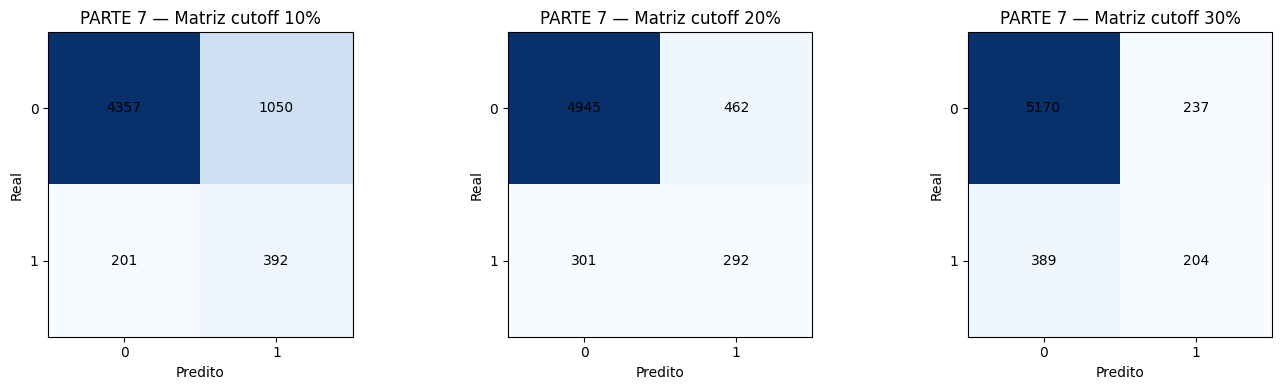

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # cria figura com 3 painéis

for i, cutoff in enumerate(cutoffs_fixos):  # percorre cada cutoff
    y_pred = (proba_log_test >= cutoff).astype(int)  # converte probabilidade em classe prevista
    cm = confusion_matrix(y_test, y_pred)  # calcula matriz de confusão

    axes[i].imshow(cm, cmap='Blues')  # desenha matriz como heatmap
    axes[i].set_title(f'PARTE 7 — Matriz cutoff {int(cutoff*100)}%')  # define título padronizado
    axes[i].set_xlabel('Predito')  # define eixo X
    axes[i].set_ylabel('Real')  # define eixo Y
    axes[i].set_xticks([0, 1])  # define rótulos do eixo X
    axes[i].set_yticks([0, 1])  # define rótulos do eixo Y

    for r in range(2):
        for c in range(2):
            axes[i].text(c, r, int(cm[r, c]), ha='center', va='center')  # escreve valores da matriz

plt.tight_layout()  # ajusta espaçamento
plt.show()  # renderiza gráfico


## 8) Treinar os 3 modelos e comparar

Treinaremos: LogisticRegression, DecisionTree(max_depth=5), GradientBoosting.


In [24]:
model_specs = {  # define os três modelos da comparação
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
}

pipelines = {}  # dicionário para armazenar modelos treinados
proba_models = {}  # dicionário para armazenar probabilidades no teste

for nome, modelo in model_specs.items():  # percorre cada modelo
    pipe = Pipeline(steps=[('prep', prep), ('model', modelo)])  # monta pipeline completo
    pipe.fit(X_train, y_train)  # treina pipeline
    proba_models[nome] = pipe.predict_proba(X_test)[:, 1]  # salva probabilidades previstas no teste
    pipelines[nome] = pipe  # salva pipeline treinado


### 8.1) Tabela de AUC e PR-AUC por modelo

O que observar: comparação justa no mesmo teste temporal.


In [25]:
rows_model = []  # lista para montar tabela de métricas por modelo

for nome in model_specs.keys():  # percorre nomes dos modelos
    proba = proba_models[nome]  # lê probabilidade do modelo
    rows_model.append({
        'modelo': nome,
        'AUC_teste': roc_auc_score(y_test, proba),
        'PR_AUC_teste': average_precision_score(y_test, proba),
    })

metrics_models = pd.DataFrame(rows_model).sort_values('AUC_teste', ascending=False).reset_index(drop=True)  # cria ranking por AUC

metrics_models_fmt = metrics_models.copy()  # cria cópia para formatação de saída
metrics_models_fmt['AUC_teste'] = metrics_models_fmt['AUC_teste'].map(lambda x: f'{x:.4f}')  # formata AUC
metrics_models_fmt['PR_AUC_teste'] = metrics_models_fmt['PR_AUC_teste'].map(lambda x: f'{x:.4f}')  # formata PR-AUC

metrics_models_fmt  # exibe tabela formatada sem usar Styler


,modelo,AUC_teste,PR_AUC_teste
0,LogisticRegression,0.8103,0.4011
1,GradientBoostingClassifier,0.8052,0.3949
2,DecisionTreeClassifier,0.7892,0.3412


> **Callout FP&A**  
AUC = separação (**modelo**).


### 8.2) ROC dos 3 modelos (Plotly)

Legenda já mostra AUC de cada curva.


In [26]:
fig = go.Figure()  # cria figura ROC comparativa

for nome in model_specs.keys():  # percorre cada modelo
    fpr, tpr, _ = roc_curve(y_test, proba_models[nome])  # calcula pontos ROC
    auc_val = roc_auc_score(y_test, proba_models[nome])  # calcula AUC
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{nome} (AUC={auc_val:.3f})'))  # adiciona curva com AUC na legenda

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))  # adiciona diagonal
fig.update_layout(title='PARTE 8 — ROC dos 3 modelos (TESTE)', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


### 8.3) Precision-Recall dos 3 modelos (Plotly)

Legenda já mostra PR-AUC de cada curva.


In [27]:
fig = go.Figure()  # cria figura PR comparativa

for nome in model_specs.keys():  # percorre cada modelo
    precision_arr, recall_arr, _ = precision_recall_curve(y_test, proba_models[nome])  # calcula curva PR
    pr_auc_val = average_precision_score(y_test, proba_models[nome])  # calcula PR-AUC
    fig.add_trace(go.Scatter(x=recall_arr, y=precision_arr, mode='lines', name=f'{nome} (PR-AUC={pr_auc_val:.3f})'))  # adiciona curva com PR-AUC

fig.update_layout(title='PARTE 8 — Precision-Recall dos 3 modelos (TESTE)', xaxis_title='Recall', yaxis_title='Precision')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


Leitura FP&A: ROC mostra separação global; PR destaca desempenho na classe default.


## 9) Overfitting na árvore (max_depth)

Árvore profunda pode decorar treino. Vamos comparar AUC de treino e teste por profundidade.


In [28]:
depths = list(range(1, 16))  # define profundidades para experimento
auc_train_depth = []  # lista para armazenar AUC de treino
auc_test_depth = []  # lista para armazenar AUC de teste

for d in depths:  # percorre cada profundidade
    tree_tmp = DecisionTreeClassifier(max_depth=d, random_state=42)  # cria árvore com depth atual
    pipe_tmp = Pipeline(steps=[('prep', prep), ('model', tree_tmp)])  # monta pipeline temporário
    pipe_tmp.fit(X_train, y_train)  # treina no conjunto de treino

    proba_train_tmp = pipe_tmp.predict_proba(X_train)[:, 1]  # prevê probabilidades no treino
    proba_test_tmp = pipe_tmp.predict_proba(X_test)[:, 1]  # prevê probabilidades no teste

    auc_train_depth.append(roc_auc_score(y_train, proba_train_tmp))  # salva AUC de treino
    auc_test_depth.append(roc_auc_score(y_test, proba_test_tmp))  # salva AUC de teste


### 9.1) Plot de overfitting

Quando treino sobe demais e teste cai, há overfitting.


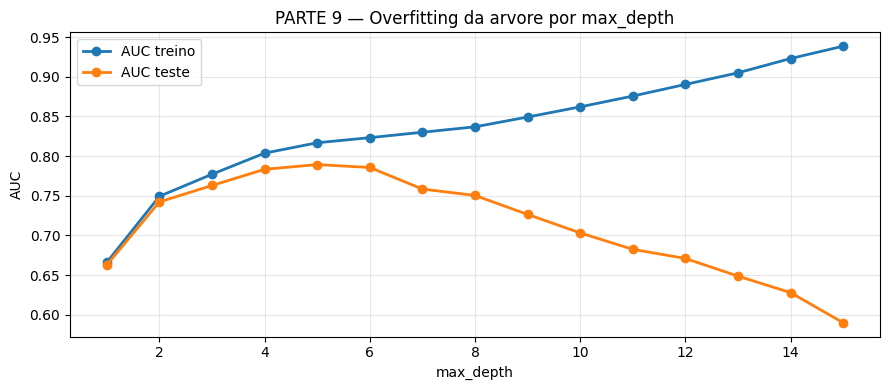

In [29]:
fig, ax = plt.subplots(figsize=(9, 4))  # cria figura para curva de overfitting
ax.plot(depths, auc_train_depth, marker='o', linewidth=2, label='AUC treino')  # plota curva de treino
ax.plot(depths, auc_test_depth, marker='o', linewidth=2, label='AUC teste')  # plota curva de teste
ax.set_title('PARTE 9 — Overfitting da arvore por max_depth')  # define título padronizado
ax.set_xlabel('max_depth')  # define eixo X
ax.set_ylabel('AUC')  # define eixo Y
ax.grid(alpha=0.3)  # adiciona grade
ax.legend()  # exibe legenda
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


Leitura FP&A: controlar complexidade e validar no tempo evita decisões superotimizadas no passado.


## 10) Interpretação: coeficientes e importances

Começaremos com a logística para direção de risco, depois árvores para importância relativa.


In [30]:
log_pipe = pipelines['LogisticRegression']  # recupera pipeline da logística treinada

feature_names_log = log_pipe.named_steps['prep'].get_feature_names_out()  # extrai nomes após transformação
coef_vals = log_pipe.named_steps['model'].coef_[0]  # extrai coeficientes da classe positiva
coef_series = pd.Series(coef_vals, index=feature_names_log).sort_values()  # organiza série ordenada

top_neg = coef_series.head(8)  # seleciona 8 coeficientes mais negativos
top_pos = coef_series.tail(8)  # seleciona 8 coeficientes mais positivos


### 10.1) Coeficientes da logística (direção do risco)

Sinal positivo tende a aumentar risco previsto; sinal negativo tende a reduzir.


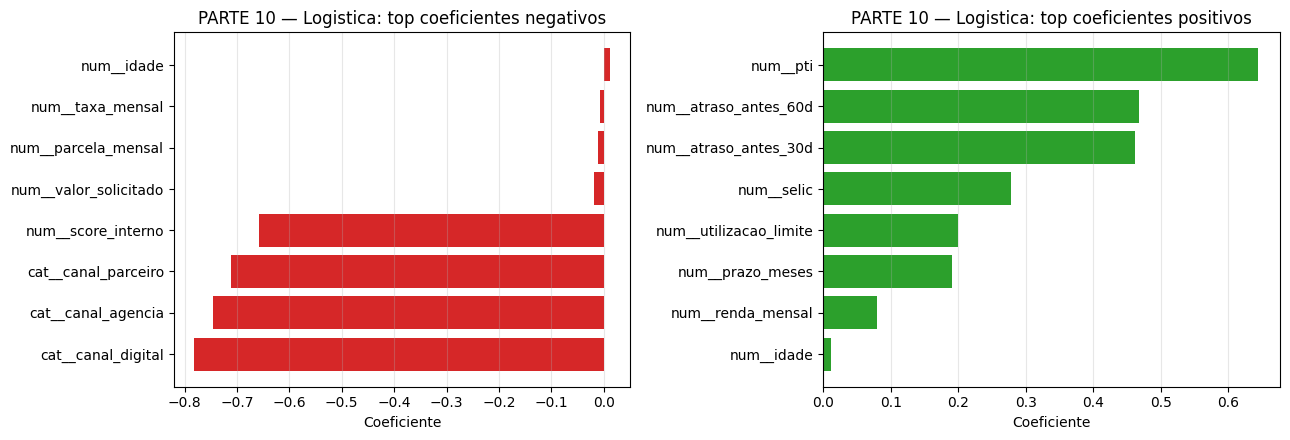

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))  # cria figura com dois painéis

axes[0].barh(top_neg.index, top_neg.values, color='#d62728')  # plota top coeficientes negativos
axes[0].set_title('PARTE 10 — Logistica: top coeficientes negativos')  # título painel esquerdo
axes[0].set_xlabel('Coeficiente')  # eixo X
axes[0].grid(axis='x', alpha=0.3)  # grade eixo X

axes[1].barh(top_pos.index, top_pos.values, color='#2ca02c')  # plota top coeficientes positivos
axes[1].set_title('PARTE 10 — Logistica: top coeficientes positivos')  # título painel direito
axes[1].set_xlabel('Coeficiente')  # eixo X
axes[1].grid(axis='x', alpha=0.3)  # grade eixo X

plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


### 10.2) Feature importance da Árvore (Top 10)

Importância ajuda priorização de discussão, mas não é causalidade.


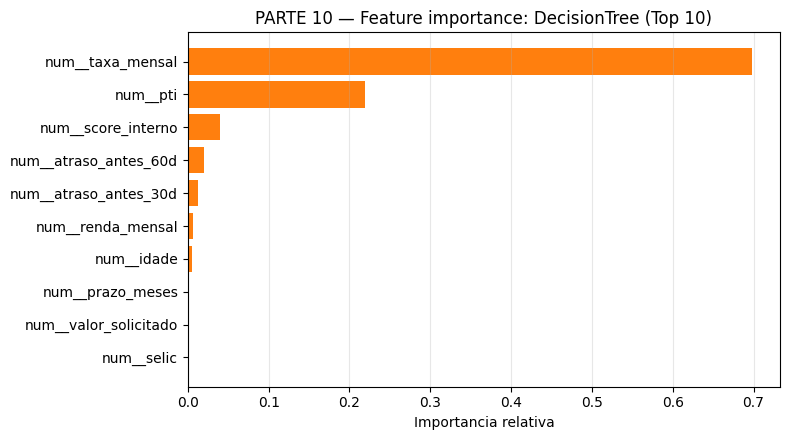

In [32]:
tree_pipe = pipelines['DecisionTreeClassifier']  # recupera pipeline da árvore treinada

names_tree = tree_pipe.named_steps['prep'].get_feature_names_out()  # extrai nomes das features transformadas
imp_tree = pd.Series(tree_pipe.named_steps['model'].feature_importances_, index=names_tree).sort_values(ascending=False)  # calcula importance

top_tree = imp_tree.head(10).sort_values()  # seleciona top 10 para plot horizontal

fig, ax = plt.subplots(figsize=(8, 4.5))  # cria figura
ax.barh(top_tree.index, top_tree.values, color='#ff7f0e')  # plota importance da árvore
ax.set_title('PARTE 10 — Feature importance: DecisionTree (Top 10)')  # define título padronizado
ax.set_xlabel('Importancia relativa')  # define eixo X
ax.grid(axis='x', alpha=0.3)  # adiciona grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


### 10.3) Feature importance do GBM (Top 10)

Compare o ranking com a árvore para avaliar estabilidade dos drivers.


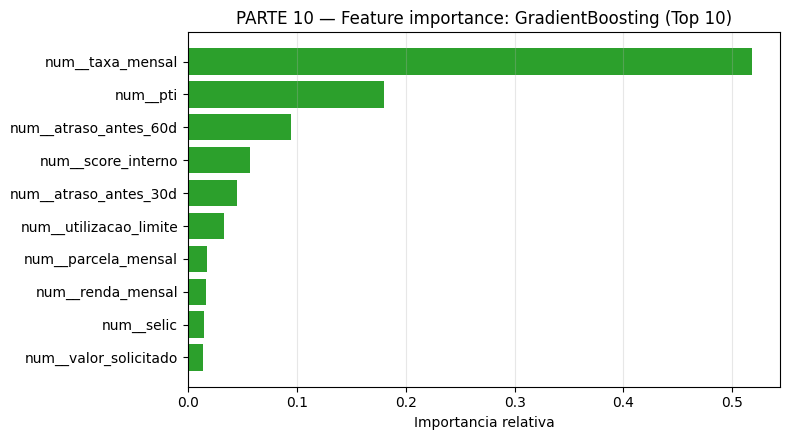

In [33]:
gbm_pipe = pipelines['GradientBoostingClassifier']  # recupera pipeline do GBM treinado

names_gbm = gbm_pipe.named_steps['prep'].get_feature_names_out()  # extrai nomes das features transformadas
imp_gbm = pd.Series(gbm_pipe.named_steps['model'].feature_importances_, index=names_gbm).sort_values(ascending=False)  # calcula importance

top_gbm = imp_gbm.head(10).sort_values()  # seleciona top 10 para plot horizontal

fig, ax = plt.subplots(figsize=(8, 4.5))  # cria figura
ax.barh(top_gbm.index, top_gbm.values, color='#2ca02c')  # plota importance do GBM
ax.set_title('PARTE 10 — Feature importance: GradientBoosting (Top 10)')  # define título padronizado
ax.set_xlabel('Importancia relativa')  # define eixo X
ax.grid(axis='x', alpha=0.3)  # adiciona grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


> **Callout FP&A**  
R$ = payoff (**custo/benefício**).


## 11) Demo executiva: grid de cutoffs (5% a 50%)

Agora vamos varrer cutoffs e procurar menor custo econômico.


In [34]:
def build_cutoff_grid(proba, y_true, test_df, cutoffs):  # constrói tabela de métricas por cutoff
    rows = []  # lista para acumular resultados
    for c in cutoffs:  # percorre cada cutoff do grid
        y_pred = (proba >= c).astype(int)  # aplica cutoff
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # extrai matriz

        mask_fp = (y_true.values == 0) & (y_pred == 1)  # identifica falsos positivos
        mask_fn = (y_true.values == 1) & (y_pred == 0)  # identifica falsos negativos

        custo_fp = test_df.loc[mask_fp, 'profit_if_good'].sum()  # soma custo de FP
        custo_fn = test_df.loc[mask_fn, 'loss_if_default'].sum()  # soma custo de FN

        rows.append({
            'cutoff': c,
            'aprovacao_pct': (y_pred == 0).mean(),
            'FP': int(fp),
            'FN': int(fn),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'custo_total_R$': float(custo_fp + custo_fn),
        })
    return pd.DataFrame(rows)  # devolve DataFrame consolidado


### 11.1) Gerar grid para Logística e GBM

O que observar: mesma régua de cutoffs para comparação justa.


In [35]:
cutoff_grid = np.arange(0.05, 0.51, 0.05)  # define cutoffs de 5% a 50%

grid_log = build_cutoff_grid(proba_models['LogisticRegression'], y_test, test, cutoff_grid)  # gera grid da logística
grid_log['modelo'] = 'LogisticRegression'  # marca nome do modelo

grid_gbm = build_cutoff_grid(proba_models['GradientBoostingClassifier'], y_test, test, cutoff_grid)  # gera grid do GBM
grid_gbm['modelo'] = 'GradientBoostingClassifier'  # marca nome do modelo

grid_all = pd.concat([grid_log, grid_gbm], ignore_index=True)  # junta tabelas para análises comparativas


### 11.2) Top-5 menores custos por modelo

O que observar: cutoff ótimo muda por modelo.


In [36]:
top_log = grid_log.nsmallest(5, 'custo_total_R$').copy()  # seleciona top-5 da logística por menor custo
top_gbm = grid_gbm.nsmallest(5, 'custo_total_R$').copy()  # seleciona top-5 do GBM por menor custo

top_view = pd.concat([top_log, top_gbm], ignore_index=True)  # junta top-5 dos dois modelos

top_view_fmt = top_view.copy()  # cria cópia para formatação executiva
for col in ['cutoff', 'aprovacao_pct', 'precision', 'recall', 'f1']:
    top_view_fmt[col] = top_view_fmt[col].map(lambda x: f'{x:.2%}')  # formata métricas percentuais

top_view_fmt['custo_total_R$'] = top_view_fmt['custo_total_R$'].map(lambda x: f'R$ {x:,.0f}')  # formata custo em moeda

top_view_fmt  # exibe tabela formatada


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_total_R$,modelo
0,20.00%,87.43%,462,301,38.73%,49.24%,43.36%,"R$ 3,615,549",LogisticRegression
1,15.00%,83.28%,671,261,33.10%,55.99%,41.60%,"R$ 3,710,762",LogisticRegression
2,25.00%,90.47%,328,349,42.66%,41.15%,41.89%,"R$ 3,755,140",LogisticRegression
3,30.00%,92.65%,237,389,46.26%,34.40%,39.46%,"R$ 3,887,800",LogisticRegression
4,10.00%,75.97%,1050,201,27.18%,66.10%,38.53%,"R$ 3,956,824",LogisticRegression
5,25.00%,90.48%,333,355,41.68%,40.13%,40.89%,"R$ 3,738,787",GradientBoostingClassifier
6,20.00%,87.80%,455,316,37.84%,46.71%,41.81%,"R$ 3,759,618",GradientBoostingClassifier
7,15.00%,84.32%,623,275,33.79%,53.63%,41.46%,"R$ 3,786,883",GradientBoostingClassifier
8,30.00%,92.68%,238,392,45.79%,33.90%,38.95%,"R$ 3,805,077",GradientBoostingClassifier
9,35.00%,94.18%,170,414,51.29%,30.19%,38.00%,"R$ 3,830,055",GradientBoostingClassifier


### 11.3) Curva custo total x cutoff (Plotly)

Legenda identifica cada modelo no trade-off econômico.


In [37]:
fig = go.Figure()  # cria figura interativa custo vs cutoff
fig.add_trace(go.Scatter(x=grid_log['cutoff'], y=grid_log['custo_total_R$'], mode='lines+markers', name='Logistica'))  # adiciona curva logística
fig.add_trace(go.Scatter(x=grid_gbm['cutoff'], y=grid_gbm['custo_total_R$'], mode='lines+markers', name='GBM'))  # adiciona curva GBM
fig.update_layout(title='PARTE 11 — Custo total (R$) vs cutoff', xaxis_title='Cutoff', yaxis_title='Custo total (R$)')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


### 11.4) Curva F1 x cutoff (Plotly)

F1 muda com a política de corte.


In [38]:
fig = go.Figure()  # cria figura interativa F1 vs cutoff
fig.add_trace(go.Scatter(x=grid_log['cutoff'], y=grid_log['f1'], mode='lines+markers', name='Logistica'))  # adiciona curva logística
fig.add_trace(go.Scatter(x=grid_gbm['cutoff'], y=grid_gbm['f1'], mode='lines+markers', name='GBM'))  # adiciona curva GBM
fig.update_layout(title='PARTE 11 — F1 vs cutoff', xaxis_title='Cutoff', yaxis_title='F1')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


## 12) Resumo executivo de cutoff ótimo

Leitura: melhor AUC não garante melhor custo; o cutoff muda tudo.


In [39]:
best_log = grid_log.loc[grid_log['custo_total_R$'].idxmin()]  # captura melhor linha da logística
best_gbm = grid_gbm.loc[grid_gbm['custo_total_R$'].idxmin()]  # captura melhor linha do GBM

campos_resumo = ['cutoff', 'aprovacao_pct', 'FP', 'FN', 'precision', 'recall', 'f1', 'custo_total_R$']  # define campos do resumo


### 12.0) Montar linhas do resumo

Transformamos os melhores cenários em duas linhas executivas (Logística e GBM).


In [40]:
rows_resumo = []  # inicializa lista final do resumo

for nome, row in [('Logistica', best_log), ('GBM', best_gbm)]:  # percorre o melhor cenário de cada modelo
    item = {'modelo': nome, 'cutoff_otimo': row['cutoff']}  # inicia dicionário com modelo e cutoff ótimo
    for campo in campos_resumo[1:]:
        item[campo] = row[campo]  # adiciona métricas e custo no dicionário final
    rows_resumo.append(item)  # adiciona linha à lista consolidada


### 12.1) Tabela executiva formatada

Resumo final com o cutoff ótimo de Logística e GBM no critério de menor custo.


In [41]:
resumo_exec = pd.DataFrame(rows_resumo)  # transforma lista em DataFrame executivo

resumo_exec_fmt = resumo_exec.copy()  # cria cópia para saída formatada
for col in ['cutoff_otimo', 'aprovacao_pct', 'precision', 'recall', 'f1']:
    resumo_exec_fmt[col] = resumo_exec_fmt[col].map(lambda x: f'{x:.2%}')  # formata percentuais da tabela

resumo_exec_fmt['custo_total_R$'] = resumo_exec_fmt['custo_total_R$'].map(lambda x: f'R$ {x:,.0f}')  # formata custo em moeda

resumo_exec_fmt  # exibe resumo final formatado


,modelo,cutoff_otimo,aprovacao_pct,FP,FN,precision,recall,f1,custo_total_R$
0,Logistica,20.00%,87.43%,462,301,38.73%,49.24%,43.36%,"R$ 3,615,549"
1,GBM,25.00%,90.48%,333,355,41.68%,40.13%,40.89%,"R$ 3,738,787"


## 13) Gains/Lift por decil (ranking de risco)

Como crédito usa na prática: ordenar por risco e olhar concentração de defaults.


In [42]:
modelo_lift = 'GradientBoostingClassifier'  # define GBM como modelo padrão para ranking

lift_df = pd.DataFrame({  # monta base para análise de ganhos
    'dt': test['dt'].values,
    'y_real': y_test.values,
    'proba': proba_models[modelo_lift],
})

lift_df = lift_df.sort_values('proba', ascending=False).reset_index(drop=True)  # ordena do maior risco para menor
lift_df['decil'] = pd.qcut(lift_df.index + 1, 10, labels=False) + 1  # cria decil 1..10 com grupos equilibrados

lift_table = lift_df.groupby('decil', as_index=False).agg(  # consolida métricas por decil
    quantidade=('y_real', 'size'),
    defaults=('y_real', 'sum'),
)
lift_table['taxa_default'] = lift_table['defaults'] / lift_table['quantidade']  # calcula taxa de default por decil
lift_table['pct_defaults_acum'] = lift_table['defaults'].cumsum() / lift_table['defaults'].sum()  # calcula ganho acumulado


### 13.1) Tabela por decil

O que observar: decil 1 deve ter taxa de default mais alta.


In [43]:
lift_table_fmt = lift_table.copy()  # cria cópia para formatar tabela de gains

lift_table_fmt['taxa_default'] = lift_table_fmt['taxa_default'].map(lambda x: f'{x:.2%}')  # formata taxa por decil
lift_table_fmt['pct_defaults_acum'] = lift_table_fmt['pct_defaults_acum'].map(lambda x: f'{x:.2%}')  # formata ganho acumulado

lift_table_fmt  # exibe tabela formatada por decil


,decil,quantidade,defaults,taxa_default,pct_defaults_acum
0,1,600,246,41.00%,41.48%
1,2,600,114,19.00%,60.71%
2,3,600,77,12.83%,73.69%
3,4,600,39,6.50%,80.27%
4,5,600,33,5.50%,85.83%
5,6,600,23,3.83%,89.71%
6,7,600,22,3.67%,93.42%
7,8,600,18,3.00%,96.46%
8,9,600,10,1.67%,98.15%
9,10,600,11,1.83%,100.00%


### 13.2) Barras de taxa de default por decil (Plotly)

Decil 1 representa os clientes de maior risco previsto.


In [44]:
fig = go.Figure()  # cria figura interativa de barras
fig.add_trace(go.Bar(x=lift_table['decil'], y=lift_table['taxa_default'], name='Taxa de default por decil'))  # adiciona barras
fig.update_layout(title='PARTE 13 — Lift: taxa de default por decil', xaxis_title='Decil (1 = maior risco)', yaxis_title='Taxa de default')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


### 13.3) Curva de gains acumulados (Plotly)

Quanto mais inclinada no início, melhor a capacidade de priorização do ranking.


In [45]:
fig = go.Figure()  # cria figura interativa para gains acumulados
fig.add_trace(go.Scatter(x=lift_table['decil'], y=lift_table['pct_defaults_acum'], mode='lines+markers', name='Defaults acumulados'))  # adiciona curva acumulada
fig.update_layout(title='PARTE 13 — Gains: % acumulado de defaults capturados', xaxis_title='Decil (1 = maior risco)', yaxis_title='% acumulado de defaults')  # configura layout
fig.show()  # renderiza gráfico


plotly figure rendered (stub)


## 14) Conclusões executivas (linguagem de comitê)

- **Logística**: benchmark interpretável, boa para governança e documentação.
- **Árvore**: didática para explicar regras, mas requer controle de overfitting.
- **GBM**: tende a melhor separação; precisa disciplina de monitoramento.
- **AUC** mede separação do modelo; **cutoff** define política de decisão.
- **Payoff em R$** deve guiar a escolha final do cutoff.


## 15) Checklist FP&A (1 minuto)

- Baseline obrigatório antes de comparar modelos.
- Split temporal obrigatório (sem embaralhar).
- Métricas no teste: AUC, PR-AUC, precision, recall, F1.
- Política de cutoff deve ser calibrada por custo/benefício em R$.
- Monitorar drift e recalibrar modelo/cutoff periodicamente.
